In [47]:
import io
import pickle
from copy import deepcopy
from matplotlib import pyplot as plt
from PIL import Image
import subprocess
from subprocess import Popen, PIPE
import random
import imageio
import numpy as np

In [48]:
from matplotlib.backends.backend_template import FigureCanvas
def plot_to_PIL(fig, dpi=100):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=dpi)
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    buf.close()
    return pil_img

def interpolate_images(img1, img2, factor):
    # Veic pāreju starp diviem attēliem
    # Factor 0 nozīmē ka pilnībā redzams tikai img1
    # Factor 1 nozīmē ka pilnībā redzams tikai img2
    # Tiek pieņemts ka attēliem ir vienādas dimensijas - ja tā nav - pats esi vainīgs
    # Tiek arī pieņemts ka abu attēlu feature vērtības ir apgabalā [0;+1] (kas ir arī SOM svaru īpašība)
    new_image = [
        [
            [img1[i][j][0]*(1-factor) + img2[i][j][0]*factor,
             img1[i][j][1]*(1-factor) + img2[i][j][1]*factor,
             img1[i][j][2]*(1-factor) + img2[i][j][2]*factor] for j in range(len(img1[0]))
        ] for i in range(len(img1))
    ]

    return new_image

def random_image(dimension):
    new_image = [[[random.random(),random.random(),random.random()] for j in range(dimension)] for i in range(dimension)]

    return new_image

# image ir NxN masīvs, kurā katrs elements ir vektors [x1, x2, x3]
def plot_som(image, meta_this_epoch=None, meta_max_epoch=None):
    fig = plt.Figure(figsize=[len(image)/20, len(image[0])/20])
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    fig.subplots_adjust(left = 0, right = 1, bottom = 0.1, top = 0.9)
    if meta_this_epoch is not None and meta_max_epoch is not None:
        ax.set_title("Epoha {} no {}".format(meta_this_epoch, meta_max_epoch))

    ax.imshow(image, interpolation='gaussian')
    #ax.axis('tight')
    #ax.axis('off')
    return fig

# image_list ir masīvs, kurš sastāv no iepriekš aprakstītā veida "images"
def som_animation(image_list, frames_per_second=30, seconds_per_epoch=1):
    previous_image = None

    #fps, duration = frames_per_epoch, frames_per_epoch * (len(image_list)-1)
    #p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'mpeg4', '-qscale', '5', '-r', str(fps), 'video.mp4'], stdin=PIPE, stdout=PIPE, shell=True)
    writer = imageio.get_writer('video.mp4', fps=frames_per_second)
    for idx, img in enumerate(image_list):
        if previous_image is None:
            # Vajag uzstādīt pirmo attēlu, no kura notiks pāreja
            previous_image = img
            continue

        for i in range(round(frames_per_second * seconds_per_epoch)):
            interp_img = interpolate_images(previous_image, img, i/(frames_per_second * seconds_per_epoch))
            fig = plot_som(interp_img, meta_this_epoch=idx, meta_max_epoch=len(image_list))
            pil_fig = plot_to_PIL(fig)
            #pil_fig.save(p.stdin, 'PNG')
            fig.clf()
            #img = createFrame(i)
            writer.append_data(np.array(pil_fig))
        previous_image = img
    writer.close()
    #p.stdin.close()
    #p.wait()

In [49]:
# Load epochs from SOM training
list_x = pickle.load( open( "all_epochs.pickle", "rb" ) )

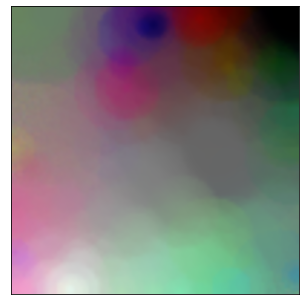

In [50]:
#list_x = [random_image(100) for i in range(2)]
plot_som(list_x[999])

In [51]:
som_animation(list_x, 30, 0.1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
